In [1]:
sentences = ["Kage is Teacher", "Mazong is Boss", 
             "Niuzong is Boss", "Xiaobing is Student",
             "Xiaoxue is Student"]
words = ' '.join(sentences).split()
word_list = list(set(words))
word_to_idx = {word: idx for idx, word in enumerate(word_list)}
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
voc_size = len(word_list)
print("词汇表：", word_list)
print("词汇到索引的字典", word_to_idx)
print("索引到词汇的字典", idx_to_word)
print("词汇表大小：", voc_size)

词汇表： ['is', 'Xiaoxue', 'Mazong', 'Kage', 'Boss', 'Teacher', 'Niuzong', 'Student', 'Xiaobing']
词汇到索引的字典 {'is': 0, 'Xiaoxue': 1, 'Mazong': 2, 'Kage': 3, 'Boss': 4, 'Teacher': 5, 'Niuzong': 6, 'Student': 7, 'Xiaobing': 8}
索引到词汇的字典 {0: 'is', 1: 'Xiaoxue', 2: 'Mazong', 3: 'Kage', 4: 'Boss', 5: 'Teacher', 6: 'Niuzong', 7: 'Student', 8: 'Xiaobing'}
词汇表大小： 9


In [2]:
#生成skip-gram训练样本
def create_skipgram_dataset(sentences, window_size=2):
    data = []
    for sentence in sentences:
        sentence = sentence.split()
        for idx, word in enumerate(sentence):
            for neighbor in sentence[max(idx-window_size, 0):min(idx+window_size, len(sentence))+1]:
                if neighbor != word:
                    data.append((neighbor, word))
    return data
skipgram_data = create_skipgram_dataset(sentences)
print("skipgram_data", skipgram_data)

skipgram_data [('is', 'Kage'), ('Teacher', 'Kage'), ('Kage', 'is'), ('Teacher', 'is'), ('Kage', 'Teacher'), ('is', 'Teacher'), ('is', 'Mazong'), ('Boss', 'Mazong'), ('Mazong', 'is'), ('Boss', 'is'), ('Mazong', 'Boss'), ('is', 'Boss'), ('is', 'Niuzong'), ('Boss', 'Niuzong'), ('Niuzong', 'is'), ('Boss', 'is'), ('Niuzong', 'Boss'), ('is', 'Boss'), ('is', 'Xiaobing'), ('Student', 'Xiaobing'), ('Xiaobing', 'is'), ('Student', 'is'), ('Xiaobing', 'Student'), ('is', 'Student'), ('is', 'Xiaoxue'), ('Student', 'Xiaoxue'), ('Xiaoxue', 'is'), ('Student', 'is'), ('Xiaoxue', 'Student'), ('is', 'Student')]


In [3]:
import torch
def one_hot_encoding(word, word_to_idx):
    tensor = torch.zeros(voc_size)
    tensor[word_to_idx[word]] = 1
    return tensor
word_example="Teacher"
print("word_example", word_example)
print("one_hot_encoding", one_hot_encoding(word_example, word_to_idx))
print("Skip-Gram data:", [(one_hot_encoding(context, word_to_idx), word_to_idx[target]) for context, target in skipgram_data[:3]])

word_example Teacher
one_hot_encoding tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.])
Skip-Gram data: [(tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]), 3), (tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.]), 3), (tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.]), 0)]


In [5]:
#define skip-gram class
import torch.nn as nn
class SkipGram(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(SkipGram, self).__init__()
        self.input_to_hidden = nn.Linear(voc_size, embedding_size, bias=False)
        self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias=False)
    def forward(self, x):
        hidden = self.input_to_hidden(x)
        output = self.hidden_to_output(hidden)
        return output
embedding_size = 5
model = SkipGram(voc_size, embedding_size)
print(model)

SkipGram(
  (input_to_hidden): Linear(in_features=9, out_features=5, bias=False)
  (hidden_to_output): Linear(in_features=5, out_features=9, bias=False)
)


Epoch: 100/1000, Loss: 1.2360
Epoch: 200/1000, Loss: 1.2358
Epoch: 300/1000, Loss: 1.2357
Epoch: 400/1000, Loss: 1.2355
Epoch: 500/1000, Loss: 1.2354
Epoch: 600/1000, Loss: 1.2352
Epoch: 700/1000, Loss: 1.2351
Epoch: 800/1000, Loss: 1.2350
Epoch: 900/1000, Loss: 1.2349
Epoch: 1000/1000, Loss: 1.2348


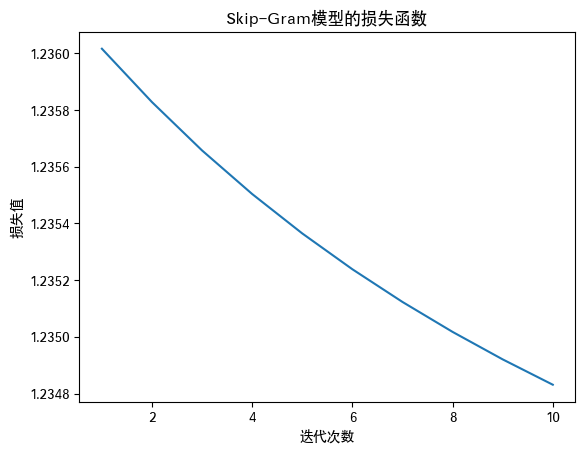

In [14]:
#训练Skip-Gram类
learning_rate = 0.001
epochs = 1000
criterion = nn.CrossEntropyLoss()
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for epoch in range(epochs):
    total_loss = 0
    for context, target in skipgram_data:
        model.zero_grad()
        X = one_hot_encoding(target, word_to_idx).float().unsqueeze(0)
        y_true = torch.tensor([word_to_idx[context]], dtype=torch.long)
        y_pred = model(X)
        loss = criterion(y_pred, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 100 == 0:
        print(f'Epoch: {epoch+1}/{epochs}, Loss: {total_loss/len(skipgram_data):.4f}')
        losses.append(total_loss/len(skipgram_data))
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Hei']
plt.rcParams['font.sans-serif'] = ['Hei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(range(1, epochs//100 + 1), losses)
plt.title('Skip-Gram模型的损失函数')
plt.xlabel('迭代次数')
plt.ylabel('损失值')
plt.show()